This code will generate 3x1 monthly image means for IR1

In [40]:
from mats_utils.rawdata.read_data import read_MATS_data
import datetime as DT
import argparse
from datetime import date, timedelta
from mats_utils.plotting.plotCCD import all_channels_plot
#from mats_utils.daily_preview.temp_nadirs import NADIR_geolocation, average_stacking
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil
import cartopy.crs as ccrs
import sys
import os
from multiprocessing import Manager
import matplotlib
import xarray as xr
import scipy
import proplot as pplt
from mats_utils.imagetools.additional_fields import add_field_with_subtracted_rolling_mean, add_field_with_subtracted_rolling_mean2
def stack(image):
    stacked_im=np.stack(image.values)
    return stacked_im

In [41]:
df=pd.read_pickle(f'/Users/lindamegner/MATS/MATS-retrieval/data/BjornsData/022023_2.pk1')


In [42]:
mytime=df['TPlocaltime'][0]


/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


monthstring 022023
Processing 022023_2


/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-

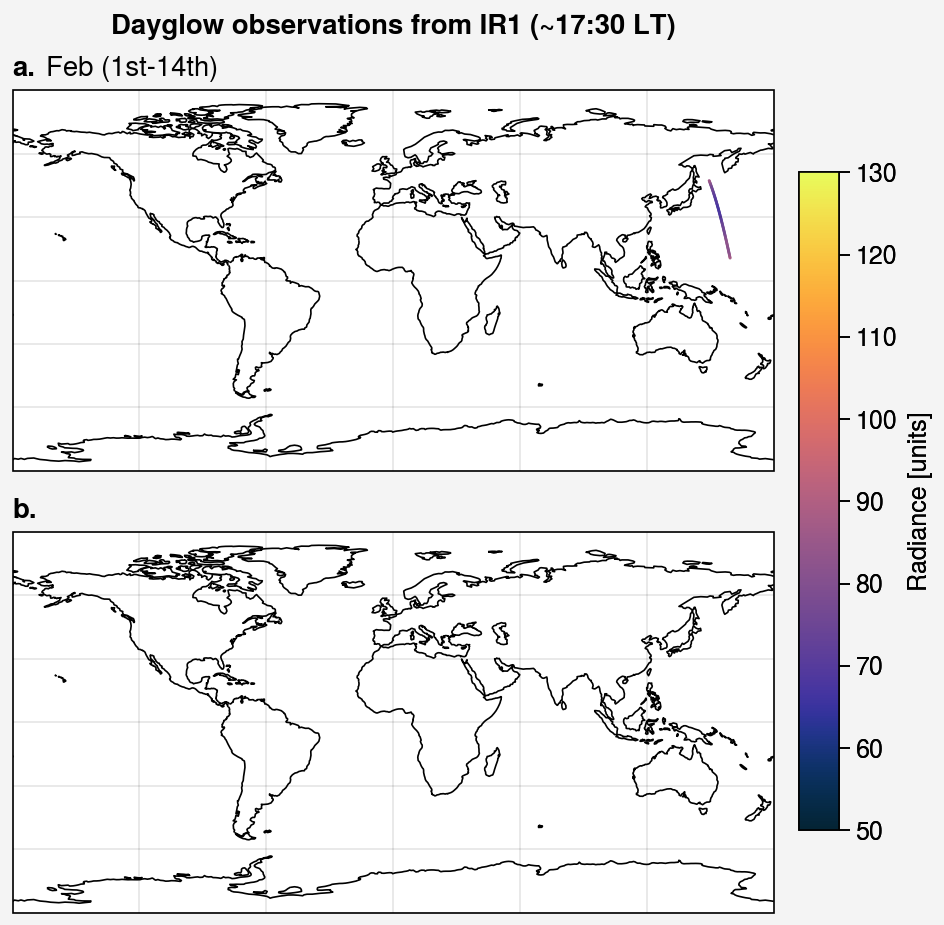

In [44]:
# ASCENDING MAP PLOT /// UPDATED TO READ FROM L1b_v05

fig = pplt.figure(figwidth='12cm')
axs = fig.subplots(ncols=1, nrows=2, proj='cyl')
fig.format(suptitle='Dayglow observations from IR1 (~17:30 LT)',abc='a.',abcborder=False)
axs.format(coast=True,landzorder=4,latlines=30, lonlines=60)
#axs.format(lonlabels='b')
#axs[0].format(latlabels='l')
#axs[3].format(latlabels='l')


#monthstrings=["022023_2","032023_1","032023_2","042023_1"]
monthstrings=["022023_1","032023_1","042023_1","022023_2","032023_2",False]
monthstrings=["022023","032023","042023"]
monthstrings=["022023"]

#monthstrings=["022023_1","032023_1",False,False,False,False]
#monthstrings=[False,"032023_1",False,False,False,False]
# dayglow
dmin,dmax = 0, 95
ascending = True

def stack(image):
    stacked_im=np.stack(image.values)
    return stacked_im

i=0
subtitles=['Feb (1st-14th)']#, 'Feb (15st-28th)','March (1st-14th)', 'March (15st-31st)','April (1st-14th)', 'April (15st-31st)']
for monthstring in monthstrings:
    print('monthstring',monthstring)
    for offset in [1]:
        for j in [1]:
            week = j + offset
            print(f'Processing {monthstring}_{week}')
            df=pd.read_pickle(f'/Users/lindamegner/MATS/MATS-retrieval/data/BjornsData/{monthstring}_{week}.pk1')
            df=df[:100]

            #df=pd.read_pickle(f'/media/waves/AVAGO/data/MATS/pandas_csv/L1b_v05/7070/CCDSEL1/alts_80to90/finished/{monthstring}_{week}.pk1')

            midday=DT.time(12, 0, 0)

            # STUPID ERROR IN FEB PART 1
            df = df[(df['CCDSEL'] == 1)]

            # ascending
            if ascending:
                df = df[(df['TPlocaltime'].dt.time > midday)]
            else:
                df = df[(df['TPlocaltime'].dt.time < midday)]

            heights=np.array([80,81,82,83,84,85,86,87,88,89,90])

            df.ImageCalibrated= df.ImageCalibrated.apply(np.mean, axis=1)
            df.ImageCalibrated = df.ImageCalibrated.div(df.TEXPMS/1000)
            #add_field_with_subtracted_rolling_mean(df, 'ImageCalibrated', 'ImageCalibrated_minus_rolling_mean', window_before=20, window_after=20, skipbefore=5, skipafter=5)
            #df.ImageCalibrated_minus_rolling_mean_std= df.ImageCalibrated.apply(np.std, axis=1)

            stacked_im=stack(df.ImageCalibrated)
            CCDs =xr.Dataset(data_vars=dict(
                        mean_im=(["time", "height"], stacked_im[:,:]),
                        lon=(["time"], df["TPlon"]),
                        lat=(["time"], df["TPlat"])),
            coords=dict(
                time=pd.to_datetime(df["EXPDate"]),
                height=heights),

            attrs=dict(description="CCD data."),
            )

            CCDs=CCDs.sel(height=86).where(CCDs.sel(height=86).mean_im > 20)

            m=axs[0].scatter(CCDs.lon.values,CCDs.lat.values,c=CCDs.mean_im.values,s=0.2,cmap='Thermal',vmin=50,vmax=130)
            axs[0].format(title=subtitles[i], titleloc='l')
        
        i=i+1

#axs[1].colorbar(m)
fig.colorbar(m, label="Radiance [units]",loc='r',length=0.8)

#fig.save('/home/waves/projects/MATS/global_patterns/notebooks/paper_figures/output/test.png',format='png')

In [30]:
CCDs['TPlocaltime']

      

KeyError: 'TPlocaltime'

In [8]:
fig.save('/home/waves/projects/MATS/global_patterns/notebooks/paper_analysis/output/test.png',format='png')

/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-

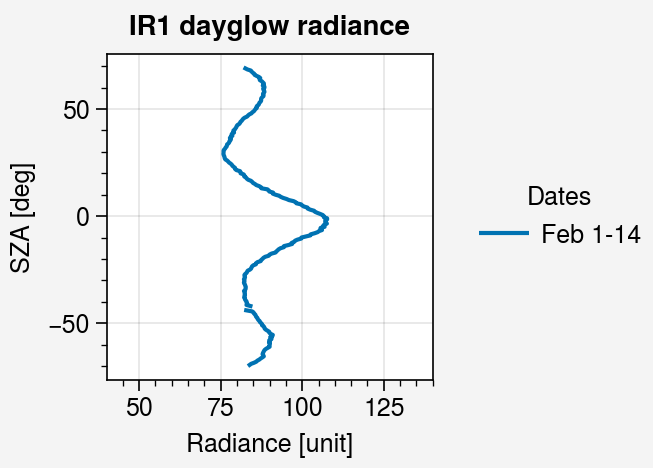

In [31]:
# ZONAL MEAN
fig, ax = pplt.subplots(suptitle='IR1 dayglow radiance', xlabel='Radiance [unit]', ylabel='SZA [deg]',figwidth='8.3cm')

monthstrings=["022023_1","022023_2","032023_1","032023_2","042023_1",False]
monthstrings=["022023_2"]
#monthstrings=["022023_1","022023_2",False,False,False,False]
#monthstrings=[False,"032023_1",False,False,False,False]
#monthstrings=[False,"042023_1",False,"032023_2",False,"022023_1"]
legends=["Feb 1-14","Feb 15-28","Mar 1-14","Mar 14-31","Apr 1-14","Apr 14-30"]
x_bins = np.arange(-70,70,0.5)
# dayglow
dmin,dmax = 0, 95
ascending = True

def stack(image):
    stacked_im=np.stack(image.values)
    return stacked_im

i=0
for monthstring in monthstrings:


        
    CCDs=pd.read_pickle(f'/Users/lindamegner/MATS/MATS-retrieval/data/BjornsData/{monthstring}.pk1')

    midday=DT.time(12, 0, 0)

    CCDs = CCDs[(CCDs['CCDSEL'] == 1)]

    # ascending
    if ascending:
        CCDs = CCDs[(CCDs['TPlocaltime'].dt.time > midday)]
    else:
        CCDs = CCDs[(CCDs['TPlocaltime'].dt.time < midday)]


    heights=np.array([80,81,82,83,84,85,86,87,88,89,90])
    CCDs.ImageCalibrated = CCDs.ImageCalibrated.apply(np.mean, axis=1)
    CCDs.ImageCalibrated = CCDs.ImageCalibrated.div(CCDs.TEXPMS/1000)
    stacked_im=stack(CCDs.ImageCalibrated)
    
    CCDs =xr.Dataset(data_vars=dict(
                mean_im=(["time", "height"], stacked_im[:,:]),
                lon=(["time"], CCDs["TPlon"]),
                lat=(["time"], CCDs["TPlat"]),
                sza=(["time"], CCDs["TPsza"]),
                ssa=(["time"], CCDs["TPssa"])),
    coords=dict(
        time=pd.to_datetime(CCDs["EXPDate"]),
        height=heights),

    attrs=dict(description="CCD1 data."),
    )

    CCDxs=CCDs.sel(height=86).where(CCDs.sel(height=86).mean_im > 0)
    CCDxs=CCDxs.groupby_bins("lat", x_bins).mean(dim='time').rolling(lat_bins=2).mean()

    #CCDxs.mean_im.values
    ax.plot(CCDxs.mean_im.values,x_bins[:-1],label=legends[i])
    #ax.scatter(CCDxs.mean_im.values[0:-1:10],CCDxs.sza[0:-1:10],s=0.2,label=legends[i],alpha=0.2)
    #ax.legend()
    i=i+1

ax.format(xlim=(40,140))
fig.legend(ncols=1, label='Dates', frame=False, loc='r')


/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-

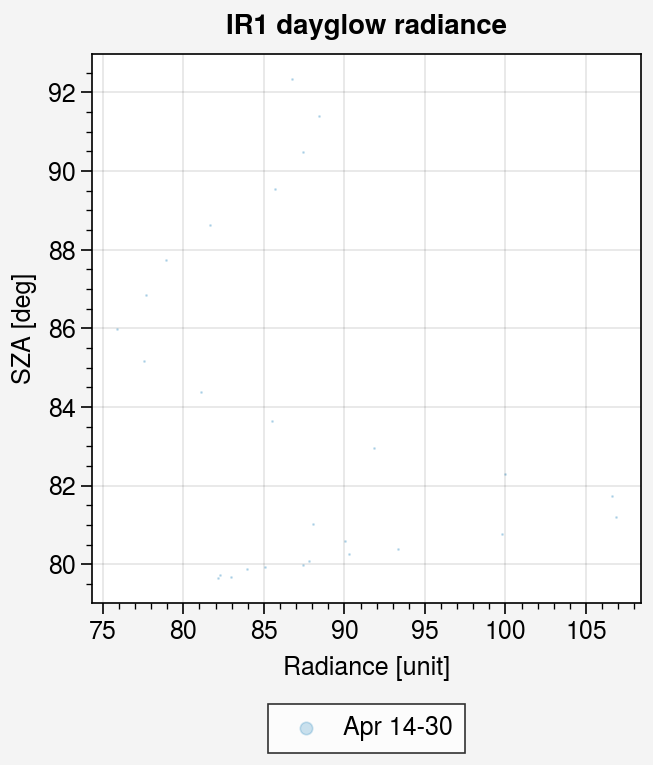

In [33]:
fig, ax = pplt.subplots(suptitle='IR1 dayglow radiance', xlabel='Radiance [unit]', ylabel='SZA [deg]',figwidth='8.3cm')
ax.scatter(CCDxs.mean_im.values[0:-1:10],CCDxs.sza[0:-1:10],s=0.2,label=legends[5],alpha=0.2)
fig.legend(loc='b',markerscale=10)

/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


IndexError: index 277 is out of bounds for axis 0 with size 277

/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/Users/lindamegner/miniconda3/envs/MatsAnalysis/lib/python3.11/site-

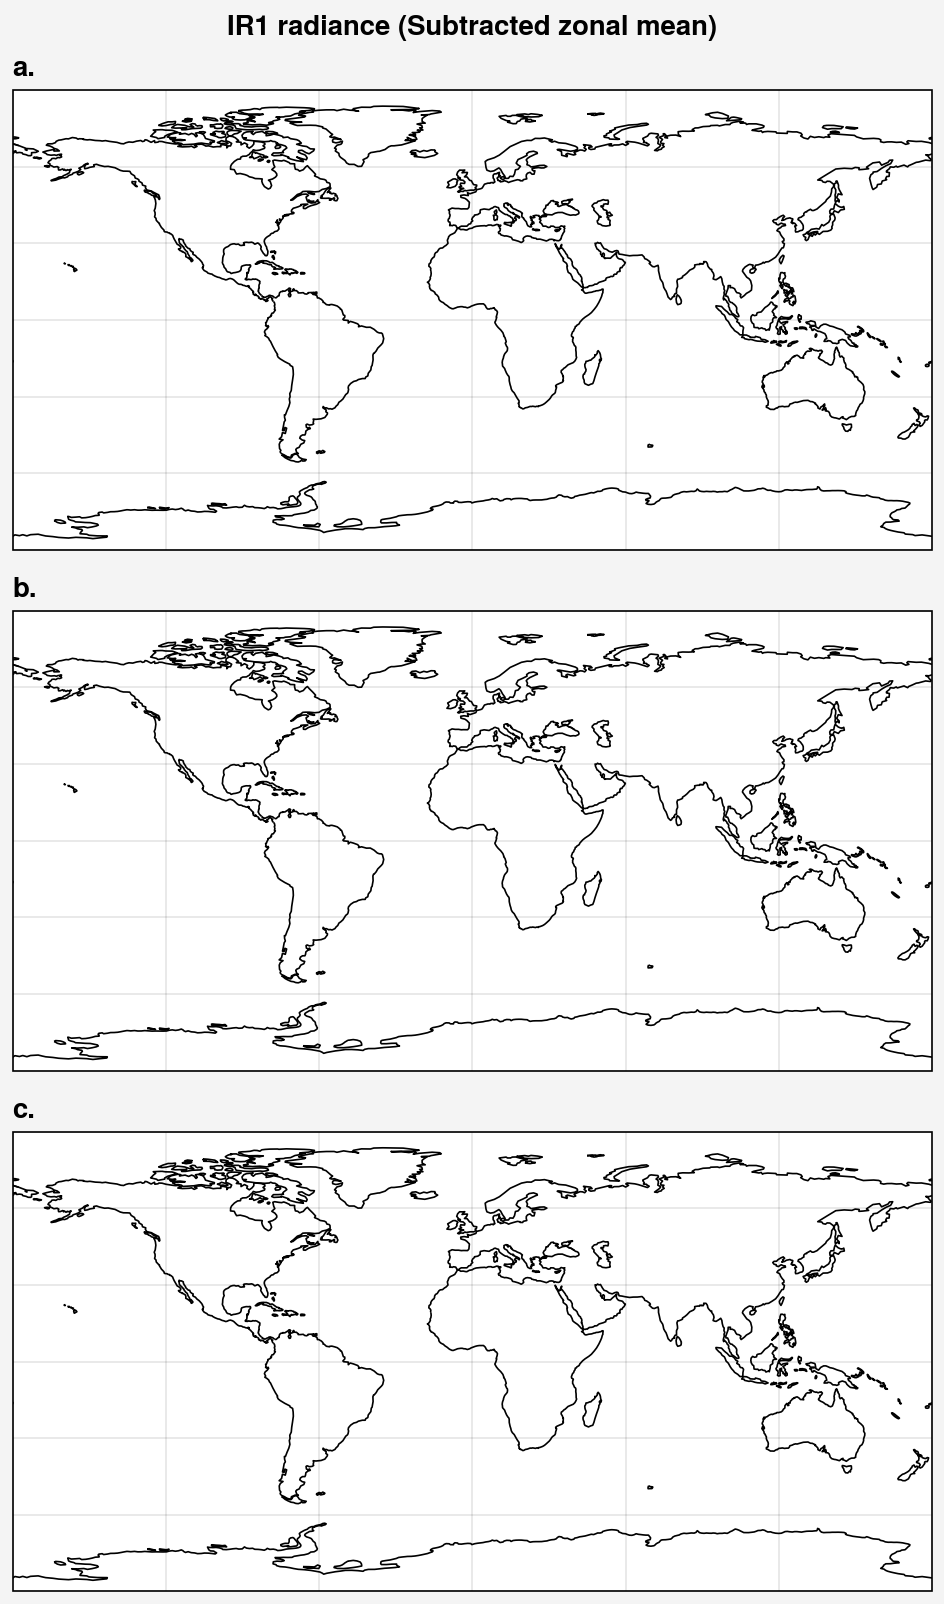

In [34]:
monthstrings=['022023_2','032023_1','032023_2']
monthstrings=['022023_2']

fig = pplt.figure(figwidth='12cm')
axs = fig.subplots(ncols=1, nrows=3, proj='cyl')
fig.format(suptitle='IR1 radiance (Subtracted zonal mean)',abc='a.',abcborder=True)
axs.format(coast=True,landzorder=4,latlines=30, lonlines=60)
i=0
for monthstring in monthstrings:
    CCDs=pd.read_pickle(f'/Users/lindamegner/MATS/MATS-retrieval/data/BjornsData/{monthstring}.pk1')

    heights=np.array([80,81,82,83,84,85,86,87,88,89,90])
    #CCDs.ImageCalibrated = CCDs.ImageCalibrated.apply(np.mean, axis=1)
    CCDs.ImageCalibrated = CCDs.ImageCalibrated.apply(np.mean, axis=1)
    CCDs.ImageCalibrated = CCDs.ImageCalibrated.div(CCDs.TEXPMS/1000)
    stacked_im=stack(CCDs.ImageCalibrated)

    CCDs =xr.Dataset(data_vars=dict(
                mean_im=(["time", "height"], stacked_im[:,:]),
                ),
    coords=dict(
        lon=(["time"], CCDs["TPlon"]),
        lat=(["time"], CCDs["TPlat"]),
        time=pd.to_datetime(CCDs["EXPDate"]),
        height=heights),

    attrs=dict(description="CCD1 data."),
    )

    CCDs=CCDs.sel(height=86).where(CCDs.sel(height=86).mean_im > 20)

    x_bins = np.arange(-70,70,0.5)

    CCDmeans=CCDs.groupby_bins("lat", x_bins) - CCDs.groupby_bins("lat", x_bins).mean(dim='time').rolling(lat_bins=1).mean()
    
    CCDmeans=CCDmeans.rolling(time=15).var() # no zonal mean
    #meas=CCDmeans.mean_im.rolling(time=5).mean()

    #meas=CCDmeans.mean_im.rolling(time=5).mean()
    m=axs[i].scatter(CCDmeans.lon,CCDmeans.lat,c=CCDmeans.mean_im,s=0.4,robust=90,alpha=1)
    i = i +1

fig.colorbar(m,loc='b',length=0.5)




In [7]:
CCDmeans

DatasetGroupBy, grouped over 'lat_bins'
279 groups with labels (-70.0,, -69.5], ..., (69.0,, 6....

/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate

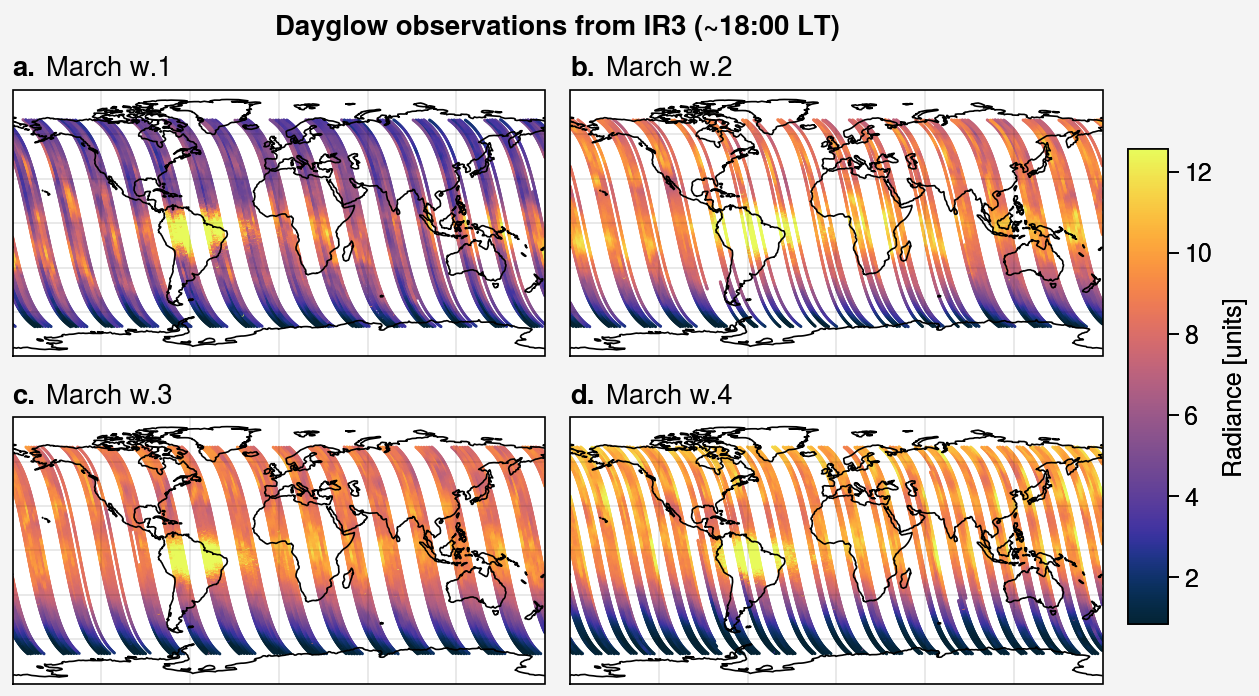

In [16]:
# ASCENDING MAP PLOT
fig = pplt.figure(figwidth='16cm')
axs = fig.subplots(ncols=2, nrows=2, proj='cyl')
fig.format(suptitle='Dayglow observations from IR3 (~18:00 LT)',abc='a.',abcborder=False)
axs.format(coast=True,landzorder=4,latlines=30, lonlines=60)
#axs.format(lonlabels='b')
#axs[0].format(latlabels='l')
#axs[3].format(latlabels='l')

#monthstrings=["022023_2","032023_1","032023_2","042023_1"]
monthstrings=["022023_1","032023_1","042023_1","022023_2","032023_2",False]
monthstrings=["032023_1","032023_2","032023_3","032023_4"]

#monthstrings=["022023_1","032023_1",False,False,False,False]
#monthstrings=[False,"032023_1",False,False,False,False]
# dayglow
dmin,dmax = 0, 95
ascending = True

def stack(image):
    stacked_im=np.stack(image.values)
    return stacked_im

i=0
subtitles=['Feb (1st-14th)', 'Feb (15st-28th)','March (1st-14th)', 'March (15st-31st)','April (1st-14th)', 'April (15st-31st)']
subtitles=['March w.1','March w.2','March w.3','March w.4']
for monthstring in monthstrings:

    if monthstring is False:
        i = i + 1

    else:
        CCDs=pd.read_pickle(f'/media/waves/AVAGO/data/MATS/pandas_csv/L1b_v05/7070/CCDSEL2/alts_80to90/finished/{monthstring}.pk1')

        midday=DT.time(12, 0, 0)

        # STUPID ERROR IN FEB PART 1
        #CCDs = CCDs[(CCDs['CCDSEL'] == 1)]

        # ascending
        if ascending:
            CCDs = CCDs[(CCDs['TPlocaltime'].dt.time > midday)]
        else:
            CCDs = CCDs[(CCDs['TPlocaltime'].dt.time < midday)]

        heights=np.array([80,81,82,83,84,85,86,87,88,89,90])
        CCDs.ImageCalibrated = CCDs.ImageCalibrated.apply(np.mean, axis=1)
        CCDs.ImageCalibrated = CCDs.ImageCalibrated.div(CCDs.TEXPMS/1000)
        stacked_im=stack(CCDs.ImageCalibrated)
        
        CCDs =xr.Dataset(data_vars=dict(
                    mean_im=(["time", "height"], stacked_im[:,:]),
                    lon=(["time"], CCDs["TPlon"]),
                    lat=(["time"], CCDs["TPlat"])),
        coords=dict(
            time=pd.to_datetime(CCDs["EXPDate"]),
            height=heights),

        attrs=dict(description="CCD1 data."),
        )

        CCDs=CCDs.sel(height=86)

        if monthstring == "022023_1":
            mean=CCDs.mean_im.mean()
            std=CCDs.mean_im.std()

        m=axs[i].scatter(CCDs.lon.values,CCDs.lat.values,c=CCDs.mean_im.values,s=0.2,robust=97,cmap='Thermal')
        axs[i].format(title=subtitles[i], titleloc='l')
        
        i=i+1

#axs[1].colorbar(m)
fig.colorbar(m, label="Radiance [units]",loc='r',length=0.8)

fig.save('/home/waves/projects/MATS/global_patterns/notebooks/paper_analysis/output/test_CCDSEL2.png',format='png')

In [40]:
CCDmeans.lon

<xarray.DataArray 'lon' (time: 70226)>
array([-50.32080741, -52.65030111, -51.3922036 , ..., -97.6997173 ,
       -98.80138596, -97.69862056])
Coordinates:
  * time      (time) datetime64[ns] 2023-02-22T08:21:41.106323 ... 2023-02-21...
    height    (time) int64 86 86 86 86 86 86 86 86 ... 86 86 86 86 86 86 86 86
    lat_bins  (time) object (50.0, 50.5] (50.5, 51.0] ... (48.5, 49.0]